# From Seismic Waves to Neural Inference: A Hands-On Introduction to Simulation-Based Inference (SBI)

## Installation and packages

Create a new conda environment:

```zsh
conda create -n compearth-workshop python=3.11 -y
conda activate compearth-workshop
```

Install jupyter:

```zsh
pip install jupyter
```

Link your kernel to the conda environment:

```zsh
python -m ipykernel install --user --name compearth-workshop --display-name "CompEarth Workshop"
```

In [2]:
!pip install torch sbi matplotlib numpy pandas pathlib
!pip install git+https://github.com/nschaetti/CompEarth_Workshop.git --upgrade

  Cloning https://github.com/nschaetti/CompEarth_Workshop.git to /tmp/pip-req-build-2er1cmqg
  Running command git clone --filter=blob:none --quiet https://github.com/nschaetti/CompEarth_Workshop.git /tmp/pip-req-build-2er1cmqg
  Resolved https://github.com/nschaetti/CompEarth_Workshop.git to commit a5d4c4c74f5c2b9f18299e118f496d4cd9cd0278
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
import os
import random
import numpy as np
import torch

seed = 42
random.seed(seed)
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
rng = np.random.default_rng(seed)

## Introduction — The Inverse Problem in Earth Sciences

### Understanding the inverse problem

### The Bayesian view

### Why Simulation-Based Inference (SBI)?

### What you will learn today

## 2 The Forward Model — Simulating Surface Wave Dispersion

### 2.1 Physical background

### 2.2 Using the simulator `surfdisp2k25`

#### Playing with the simulator

HuggingFace Space: https://huggingface.co/spaces/MIGRATE/surfdisp2k25

The `surfdisp2k25` simulator computes **Rayleigh-wave dispersion curves**, showing how the **group velocity** of surface waves varies with **period** for a given layered Earth model.

Each model is described by a set of physical and numerical parameters.

**Physical parameters**

* `n_layers` – number of layers, including the half-space at the bottom.
* `vpvs` – ratio ($V_p/V_s$), typically between 1.7 and 1.9 for crustal materials.
* `thicknesses` – list of layer thicknesses in kilometers. The last layer has a thickness of 0 to represent an infinite half-space.
* `vs_layers` – list of shear-wave velocities ($V_s$) in kilometers per second, usually increasing with depth.
* `ρ` – density of each layer, estimated here from an empirical relation ($ρ = 0.32 + 0.77 \times V_p$).

All these parameters are concatenated into a single input tensor:

$$
\theta = [,n,, V_P/V_S,, h_1, h_2, …, h_{N_{\max}},, V_{S,1}, V_{S,2}, …, V_{S,N_{\max}},]
$$

For a single model, `theta` has shape `(1, 2 + 2*Nmax)`.
When simulating several models at once, the batch dimension corresponds to the number of models.

**Numerical parameters**

* `p_min`, `p_max` – minimum and maximum periods in seconds defining the frequency range.
* `kmax` – number of discrete period samples between `p_min` and `p_max`.
* `iflsph` – Earth geometry flag: 0 for flat Earth, 1 for spherical correction.
* `iwave` – wave type: 1 for Love waves, 2 for Rayleigh waves.
* `mode` – mode number: 1 for the fundamental mode.
* `igr` – 1 to compute group velocity (dispersion curve), 0 for phase velocity only.

The simulator returns a tensor of shape `(B, kmax)` where `B` is the number of models.
Each row corresponds to a dispersion curve ($c(T)$) representing group velocity (in km/s) as a function of period (in seconds).

We now test the simulator on a simple two-layer model, representing a soft sedimentary layer over a stiffer half-space.

| Parameter        | Description                  | Value              |
| ---------------- | ---------------------------- | ------------------ |
| `n_layers`       | Number of layers             | 2                  |
| `vpvs`           | (V_P/V_S) ratio              | 1.75               |
| `thicknesses`    | Layer thicknesses (km)       | [2.0, 0.0]         |
| `vs_layers`      | Shear-wave velocities (km/s) | [2.5, 3.5]         |
| `p_min`, `p_max` | Period range (s)             | [0.5, 20.0]        |
| `kmax`           | Number of periods            | 60                 |
| `iflsph`         | Earth geometry               | 0 (flat Earth)     |
| `iwave`          | Wave type                    | 2 (Rayleigh)       |
| `mode`           | Mode number                  | 1 (fundamental)    |
| `igr`            | Velocity type                | 1 (group velocity) |


#### 2.2.1. Testing the simulator with a simple two-layer model

Let’s start by defining a model with **two layers** over a half-space.

In [4]:
from compearth.extensions.surfdisp2k25 import dispsurf2k25_simulator

# Physical model parameters
n_layers = 2                # Number of layers (including the half-space)
vpvs = 1.75                 # Vp/Vs ratio (typical for crustal rocks)
thicknesses = [0.9, 1.2, 0.34, 0.0]    # Layer thicknesses in km (0 for half-space)
vs_layers = [1.5, 1.2, 2.5, 3.5]      # Shear-wave velocities in km/s (increase with depth)

# Combine all parameters into θ = [n, vpvs, h..., vs...]
theta = torch.tensor([[n_layers, vpvs] + thicknesses + vs_layers], dtype=torch.float32)

# Numerical simulation parameters
p_min, p_max = 1.0, 5.0    # Period range in seconds
kmax = 60                   # Number of discrete period samples
iflsph = 0                  # Flat Earth approximation (0 = flat, 1 = spherical)
iwave = 2                   # Wave type (2 = Rayleigh, 1 = Love)
mode = 1                    # Fundamental mode
igr = 1                     # Compute group velocity (1 = group, 0 = phase)

print(f"Theta shape: {theta.shape}")

Theta shape: torch.Size([1, 10])


In [13]:
# Run the simulator
disp_curve = dispsurf2k25_simulator(
    theta=theta,
    p_min=p_min,
    p_max=p_max,
    kmax=108,
    iflsph=iflsph,
    iwave=iwave,
    mode=mode,
    igr=igr,
)

print("Dispersion curve shape:", disp_curve.shape)

Dispersion curve shape: torch.Size([1, 108])


In [14]:
disp_curve

tensor([[1.4450, 1.4460, 1.4469, 1.4476, 1.4482, 1.4487, 1.4490, 1.4493, 1.4494,
         1.4495, 1.4494, 1.4494, 1.4497, 1.4501, 1.4504, 1.4509, 1.4516, 1.4525,
         1.4536, 1.4553, 1.4571, 1.4596, 1.4624, 1.4663, 1.4709, 1.4767, 1.4842,
         1.4929, 1.5059, 1.5201, 1.5466, 1.5816, 1.6574, 1.6195, 1.3761, 1.2702,
         1.2804, 1.2859, 1.2897, 1.2911, 1.2922, 1.2921, 1.2918, 1.2909, 1.2899,
         1.2886, 1.2871, 1.2855, 1.2837, 1.2819, 1.2799, 1.2780, 1.2759, 1.2739,
         1.2718, 1.2696, 1.2675, 1.2654, 1.2633, 1.2611, 1.2590, 1.2569, 1.2548,
         1.2527, 1.2506, 1.2485, 1.2465, 1.2444, 1.2424, 1.2404, 1.2385, 1.2365,
         1.2346, 1.2327, 1.2308, 1.2290, 1.2272, 1.2254, 1.2237, 1.2219, 1.2202,
         1.2185, 1.2168, 1.2152, 1.2135, 1.2119, 1.2103, 1.2088, 1.2073, 1.2058,
         1.2043, 1.2029, 1.2014, 1.2000, 1.1987, 1.1973, 1.1960, 1.1947, 1.1934,
         1.1922, 1.1909, 1.1897, 1.1886, 1.1874, 1.1862, 1.1851, 1.1840, 1.1830]])

In [15]:
np.linspace(p_min, p_max, disp_curve.shape[1])

array([1.        , 1.03738318, 1.07476636, 1.11214953, 1.14953271,
       1.18691589, 1.22429907, 1.26168224, 1.29906542, 1.3364486 ,
       1.37383178, 1.41121495, 1.44859813, 1.48598131, 1.52336449,
       1.56074766, 1.59813084, 1.63551402, 1.6728972 , 1.71028037,
       1.74766355, 1.78504673, 1.82242991, 1.85981308, 1.89719626,
       1.93457944, 1.97196262, 2.00934579, 2.04672897, 2.08411215,
       2.12149533, 2.1588785 , 2.19626168, 2.23364486, 2.27102804,
       2.30841121, 2.34579439, 2.38317757, 2.42056075, 2.45794393,
       2.4953271 , 2.53271028, 2.57009346, 2.60747664, 2.64485981,
       2.68224299, 2.71962617, 2.75700935, 2.79439252, 2.8317757 ,
       2.86915888, 2.90654206, 2.94392523, 2.98130841, 3.01869159,
       3.05607477, 3.09345794, 3.13084112, 3.1682243 , 3.20560748,
       3.24299065, 3.28037383, 3.31775701, 3.35514019, 3.39252336,
       3.42990654, 3.46728972, 3.5046729 , 3.54205607, 3.57943925,
       3.61682243, 3.65420561, 3.69158879, 3.72897196, 3.76635

In [12]:
theta

tensor([[2.0000, 1.7500, 0.9000, 1.2000, 0.3400, 0.0000, 1.5000, 1.2000, 2.5000,
         3.5000]])

#### 2.2.2 Visualizing the model and its generated dispersion curve

To better understand the simulator output, we use a helper function `plot_velocity_and_dispersion` that displays both the **velocity structure** (shear-wave velocity versus depth) and the resulting **dispersion curve** (group velocity versus period).

The function takes as input:

* `thicknesses` – list of layer thicknesses in kilometers. The last one can be set to 0 to indicate the half-space of infinite thickness.
* `vs_layers` – list of shear-wave velocities (V_S) in kilometers per second, one per layer.
* `disp_curve` – the dispersion curve returned by `dispsurf2k25_simulator`, either a `torch.Tensor` or a NumPy array.
* `p_min`, `p_max` – minimum and maximum periods defining the frequency range in seconds.
* `kmax` – number of discrete periods used to compute the curve.
* `fig_size` – scaling factor for the figure size (default = 2).
* `dpi` – rendering resolution for the figure (default = 300).

The plot on the **left** shows the 1-D velocity model as a step function of depth.
Each horizontal segment corresponds to a homogeneous layer.
The plot on the **right** shows the simulated Rayleigh-wave group velocity as a function of period.
Short periods sample the shallow layers, while long periods are sensitive to deeper structures.

We now display both the model and the corresponding dispersion curve for our two-layer example.

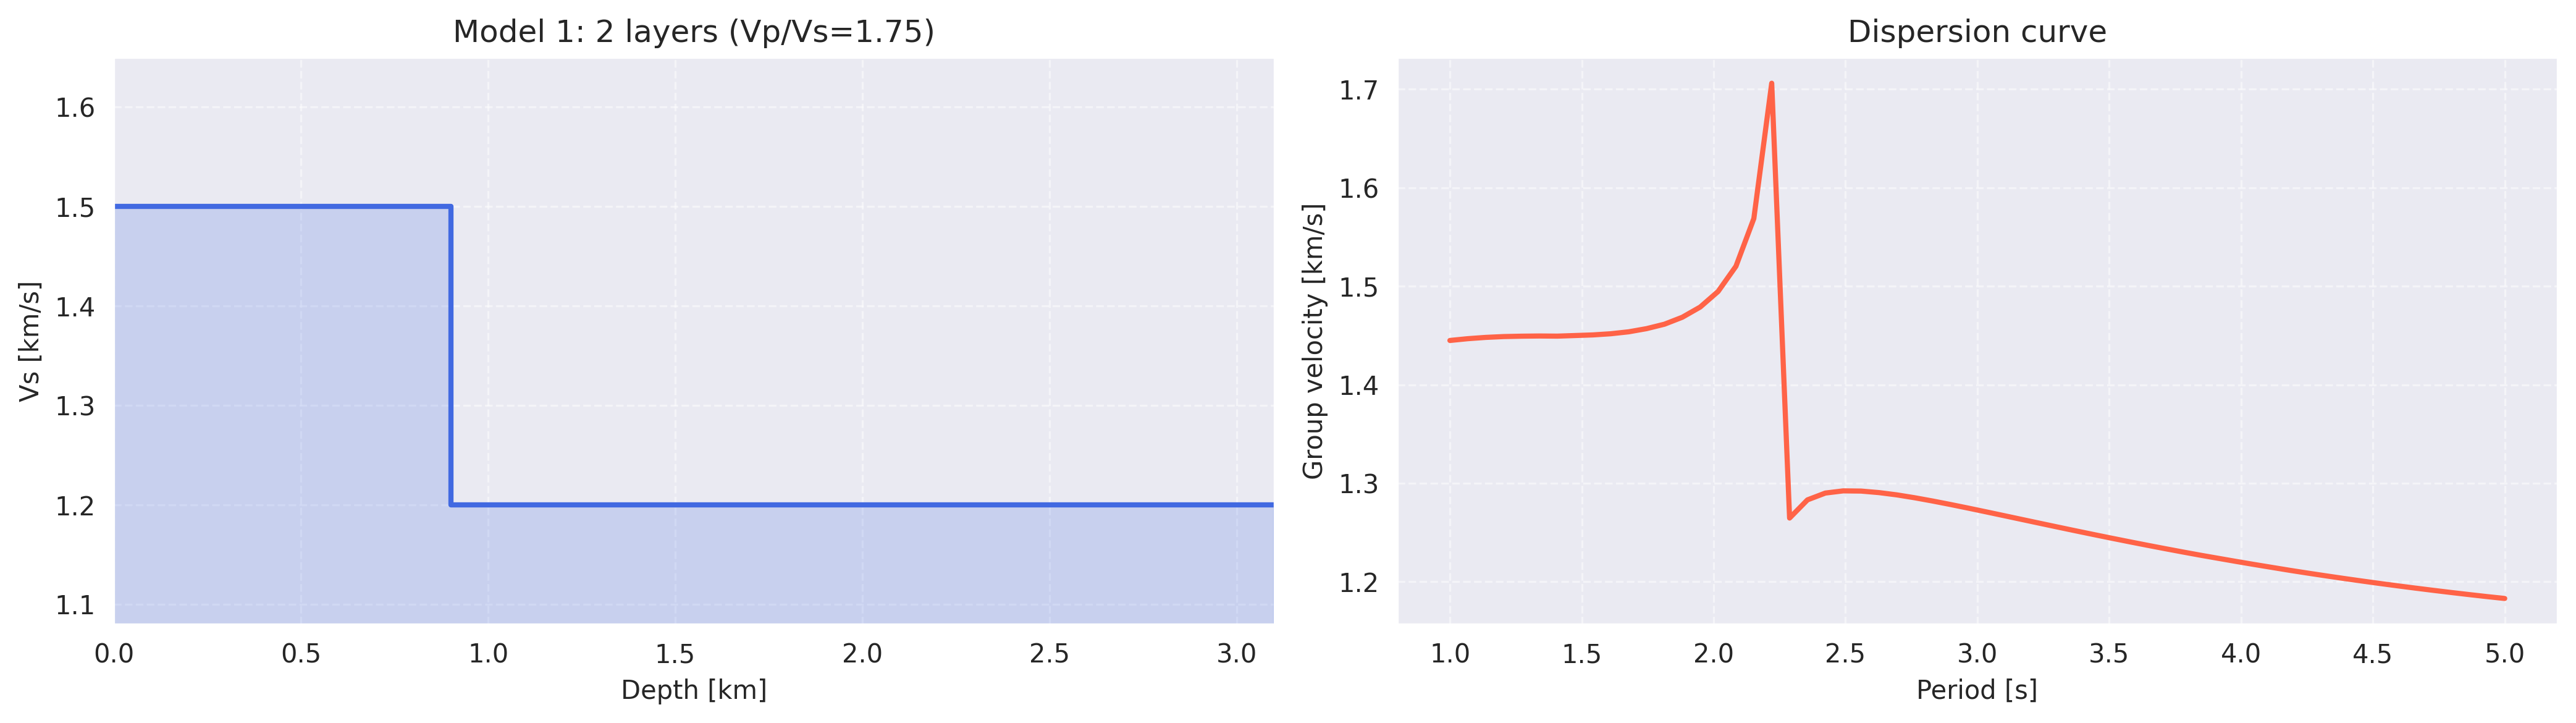

In [8]:
from compearth.utils import plot_velocity_and_dispersion

# Plot the model and the curve
plot_velocity_and_dispersion(
    theta=theta,
    disp_curve=disp_curve,
    p_min=p_min,
    p_max=p_max,
    kmax=kmax,
    dpi=300
)


#### 2.2.3. Generating multiple random models from a prior

To explore how different subsurface structures affect the dispersion curves, we now generate **random velocity models** using a simple **prior distribution** over the model parameters.

The goal is to produce a small set of plausible Earth models that will later be used to train or test an inference network.

Each model is defined by the same structure as before:

* `n` – number of layers, drawn randomly between 2 and a maximum value (`max_layers`).
* `vpvs` – fixed P-to-S velocity ratio (here 1.75).
* `h` – random layer thicknesses, uniformly sampled between 0.5 km and 5.0 km.
* `vs` – random shear-wave velocities ($V_s$), uniformly sampled between 1.5 km/s and 4.5 km/s.

For each model, these values are concatenated into a parameter vector

$$
\theta = [n, vpvs, h_1, …, h_{max}, V_{S,1}, …, V_{S,max}]
$$

We draw several such vectors to obtain a small **ensemble of synthetic models**.
Note that the last layer represents the **half-space** (infinite depth), so its thickness must remain zero and its velocity nonzero to represent the solid substrate.

In [9]:
import numpy as np
from compearth.utils import sample_models

# Sample from the prior
theta_prior, z_vnoi = sample_models(
    n_samples=8,
    layers_min=2,
    layers_max=10,
    z_min=0.0,
    z_max=5.0,
    vs_min=1.5,
    vs_max=4.5,
    thick_min=0.1,
    sort_vs=True
)
theta_prior.shape

/home/schaetti/Projets/RECHERCHES/Recherches/MIGRATE/reps/CompEarth-Workshop/compearth/utils/sampling.py:83: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  z_vnoi = torch.tensor(z_vnoi_all, dtype=torch.float32)


torch.Size([8, 22])

In [10]:
theta_prior

tensor([[8.0000, 1.7500, 0.8697, 0.3347, 0.3589, 0.4000, 0.8981, 1.2243, 0.6024,
         0.0000, 0.0000, 0.0000, 2.2146, 2.5872, 3.1637, 3.3946, 3.5471, 3.6114,
         4.0837, 4.7361, 0.0000, 0.0000],
        [3.0000, 1.7500, 2.2940, 1.6683, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 1.7077, 3.7187, 4.7825, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000],
        [2.0000, 1.7500, 4.0441, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 3.1419, 4.5923, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000],
        [9.0000, 1.7500, 0.6818, 0.1151, 0.4699, 0.4287, 0.5640, 1.0909, 0.7926,
         0.3961, 0.0000, 0.0000, 1.8982, 2.1584, 2.4291, 3.2009, 3.4923, 4.1874,
         4.2278, 4.4176, 4.7791, 0.0000],
        [7.0000, 1.7500, 0.5478, 0.5341, 0.3777, 0.5962, 1.5312, 1.1461, 0.0000,
         0.0000, 0.0000, 0.0000, 1.5510, 1.6246, 2.2675, 2.5225, 2.8857, 3.2673,
         3.8279, 0.000

In [11]:
z_vnoi

tensor([[0.5773, 1.1622, 1.2467, 1.8800, 2.0466, 3.6761, 4.4953, 4.8808, 0.0000,
         0.0000],
        [1.5995, 2.9886, 4.9360, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [3.1488, 4.9394, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.6301, 0.7335, 0.8604, 1.6733, 1.7177, 2.8013, 3.8996, 4.3864, 4.6918,
         0.0000],
        [0.2348, 0.8608, 1.3029, 1.6162, 2.4954, 4.6787, 4.7876, 0.0000, 0.0000,
         0.0000],
        [0.9472, 1.1667, 1.9056, 2.1484, 2.8189, 3.5810, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.6163, 1.8795, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1930, 3.6692, 3.7821, 4.5708, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]])

#### 2.2.4. Running the simulator on random models

We now run the simulator on the randomly sampled models.
Each parameter vector in `theta_prior` is passed to `dispsurf2k25_simulator`, which computes the corresponding dispersion curve.
The result `disp_curves` is a tensor of shape `(n_samples, kmax)`, where each row represents the group velocity curve ($c(T)$) for one model.
We also define the array of sampled periods to use for plotting.

In [25]:
# Run the simulator on the sampled models
disp_curves = dispsurf2k25_simulator(
    theta=theta_prior,
    p_min=p_min,
    p_max=p_max,
    kmax=kmax,
    iflsph=iflsph,
    iwave=iwave,
    mode=mode,
    igr=igr
)
periods = np.linspace(p_min, p_max, kmax)
disp_curves.shape

torch.Size([8, 60])

In [26]:
theta_prior[0]

tensor([6.0000, 1.7500, 1.2108, 1.2936, 0.2930, 0.3836, 0.8767, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 2.0983, 3.7449, 3.9822, 4.1545, 4.4288, 4.9300,
        0.0000, 0.0000, 0.0000, 0.0000])

In [27]:
z_vnoi[0]

tensor([0.0940, 2.3277, 2.6811, 2.9138, 3.4483, 4.6671, 0.0000, 0.0000, 0.0000,
        0.0000])

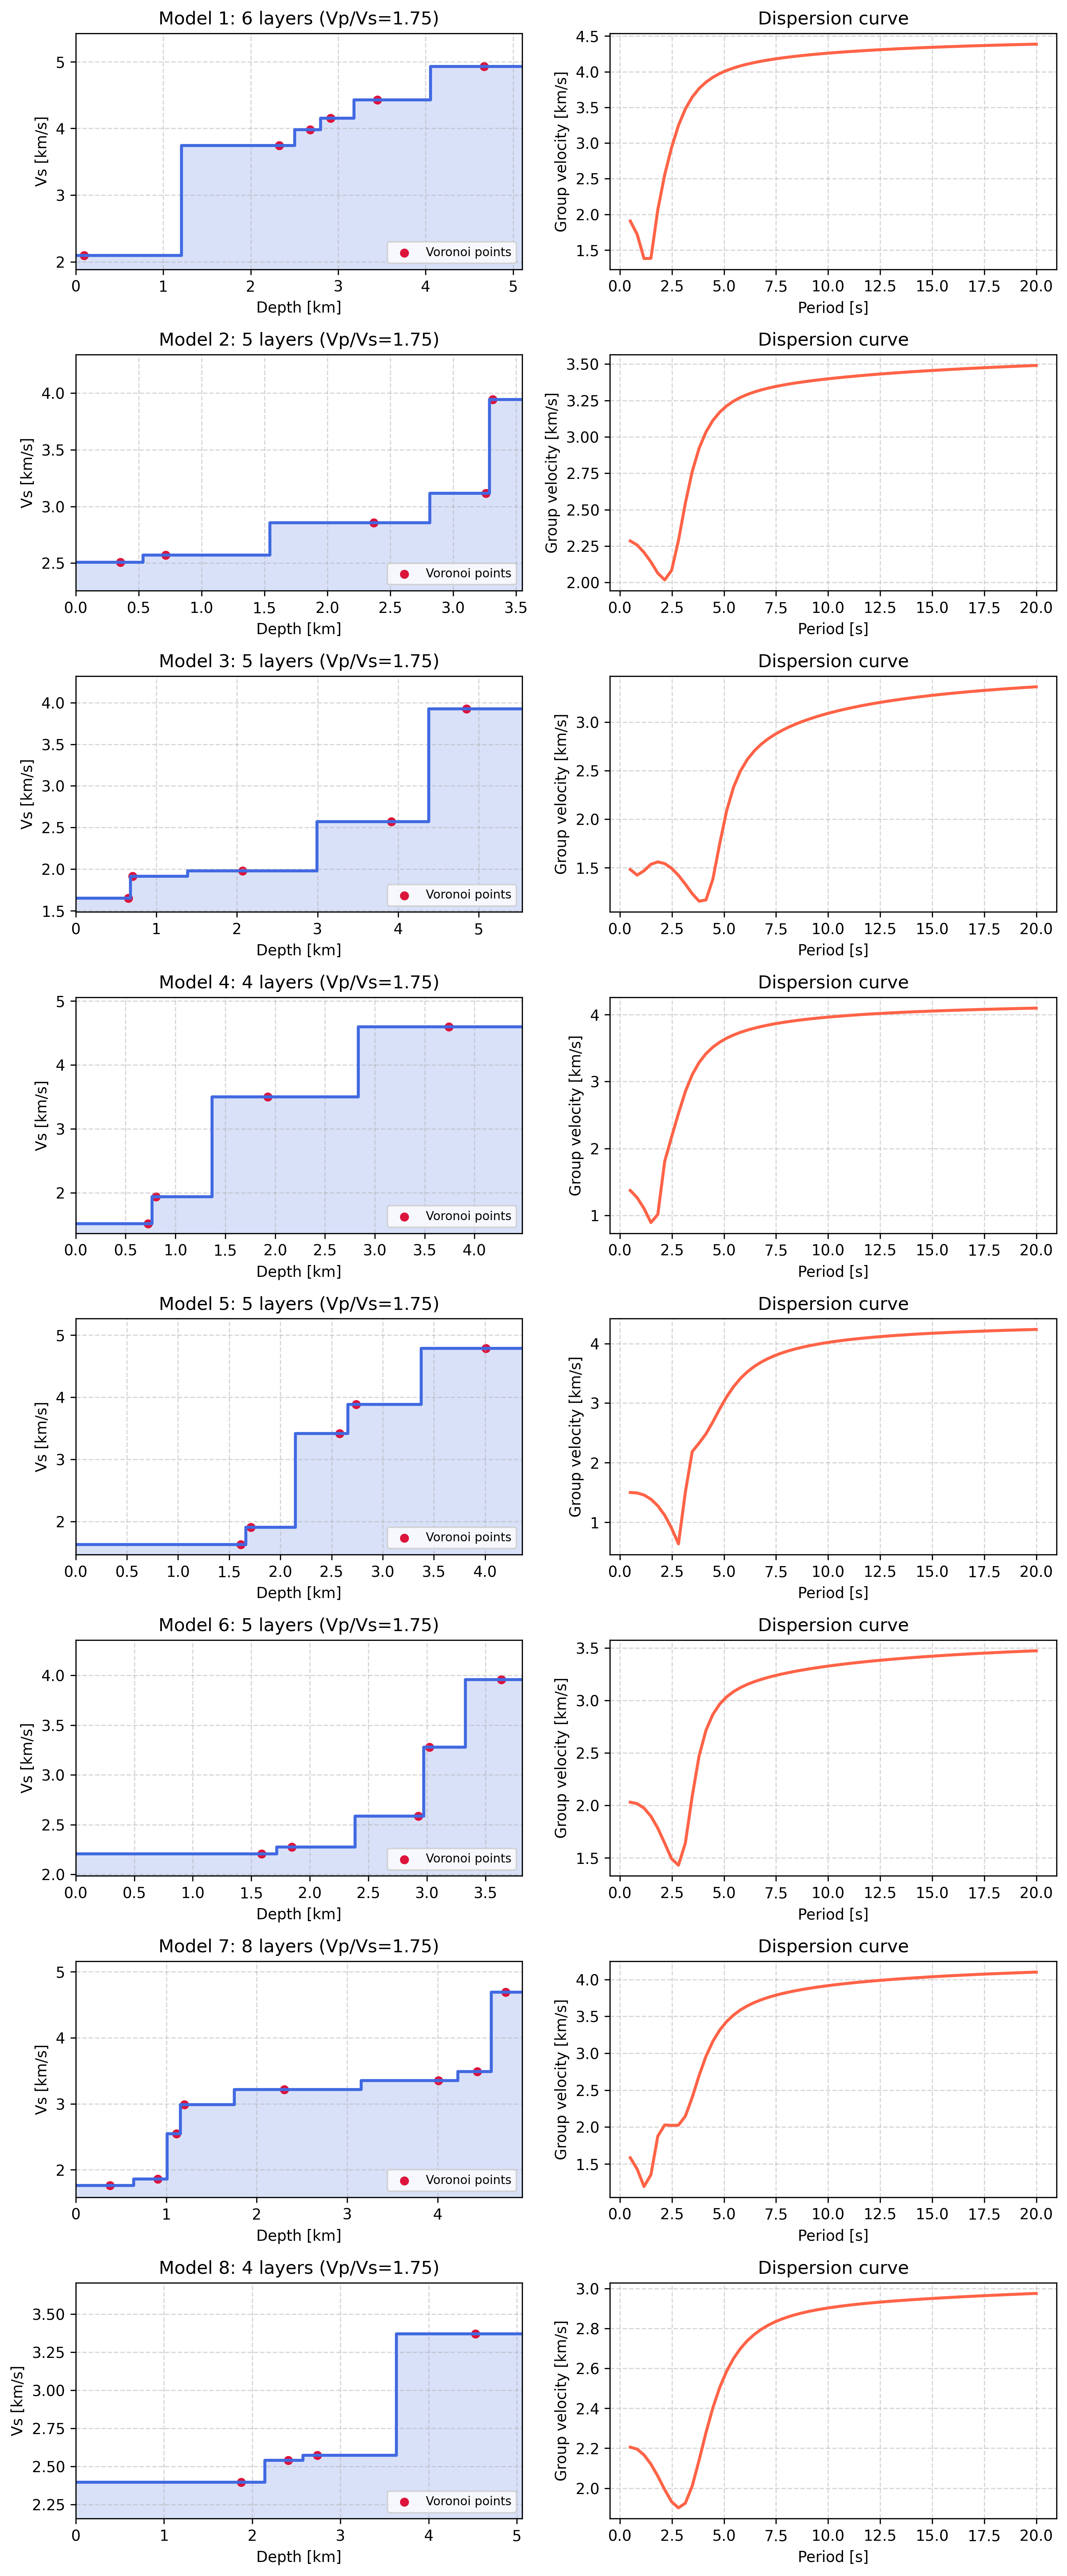

In [28]:
# Plot the model and the curve
plot_velocity_and_dispersion(
    theta=theta_prior,
    disp_curve=disp_curves,
    z_vnoi=z_vnoi,
    p_min=p_min,
    p_max=p_max,
    kmax=kmax,
    dpi=300,
    fig_size=1.5
)

*Observation:*

Each dispersion curve represents a distinct velocity model.
You can already see the **non-uniqueness** of the inverse problem: different subsurface structures can yield similar dispersion curves.

#### 2.2.5. Discussion — Why this matters

This simulator encapsulates our **forward physical model**, ($f(\theta) \rightarrow x$).
The next step will be to **invert** this mapping: given an observed curve ($x$), infer plausible models ($\theta$).
That’s precisely what *Simulation-Based Inference (SBI)* aims to achieve.

## Generating a small dataset

### Defining the problem

In this step, we select one random model from the previously sampled set.
Each model is represented as a parameter vector ($\theta$), which encodes:

1. the **number of layers** ($n$),
2. the **($V_p/V_s$)** ratio,
3. the **layer thicknesses** $(h_1, h_2, \dots )$,
4. and the **shear-wave velocities** $(V_{s,1}, V_{s,2}, \dots )$.

This vector ($\theta$) fully defines the layered Earth model.
We’ll inspect it to see how the model parameters are structured before turning it into a continuous velocity profile.

In [29]:
from compearth.utils import theta_to_velocity_profile

# Take one of the random models
theta_example = theta_prior[0]
theta_example

tensor([6.0000, 1.7500, 1.2108, 1.2936, 0.2930, 0.3836, 0.8767, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 2.0983, 3.7449, 3.9822, 4.1545, 4.4288, 4.9300,
        0.0000, 0.0000, 0.0000, 0.0000])

### Conversion to continuous velocity profile

We now convert the parametric model ($\theta$) into a **continuous velocity profile** ($V_s(z)$),
that is, a regularly sampled velocity map as a function of depth.

The function `theta_to_velocity_profile` performs the following steps:

* it takes a vector ($\theta$) as input,
* reconstructs the layer boundaries from their thicknesses,
* assigns each depth interval its corresponding shear velocity ($V_s$),
* and returns two arrays:

  * `depth`: the depth samples (in km),
  * `vs_profile`: the corresponding ($V_s$) values.

Here, we sample 60 points uniformly between 0 and 60 km depth.
The resulting table shows how shear-wave velocity varies with depth for this particular model.

In [45]:
# Convert to continuous velocity profile
depth, vs_profile = theta_to_velocity_profile(
    theta_example, 
    depth_max=5.0, 
    n_points=60
)
print(f"Depth shape: {depth.shape}")
print(f"Vs profile shape: {vs_profile.shape}")

Depth shape: (60,)
Vs profile shape: (60,)


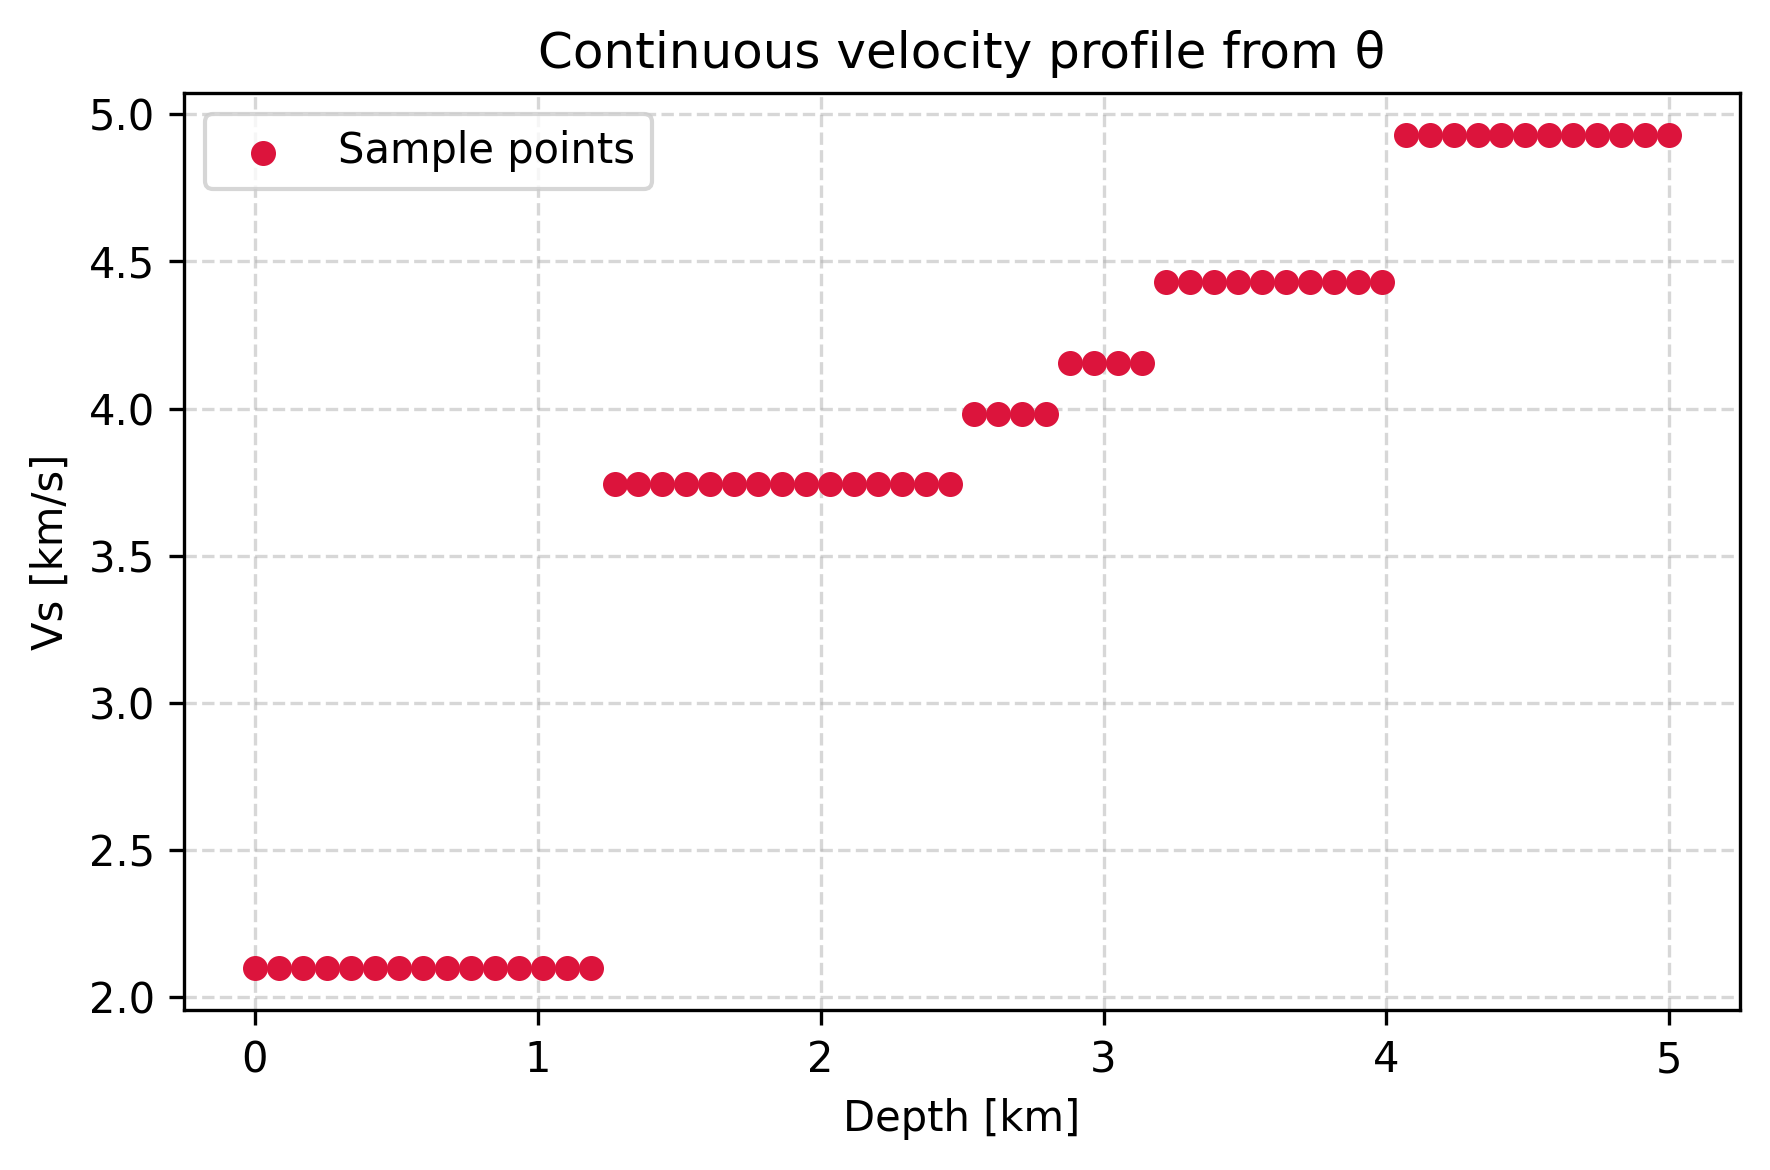

In [56]:
# Display depth and Vs in a small table
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4), dpi=300)
plt.scatter(depth, vs_profile, color='crimson', s=25, marker='o', zorder=3, label='Sample points')
plt.ylabel("Vs [km/s]")
plt.xlabel("Depth [km]")
plt.title("Continuous velocity profile from θ")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [50]:
# Generate dataset
# n_samples = 10_000
n_samples = 100
z_max = 10
vs_min = 1.5
vs_max = 4.5
thick_min = 0.1
depth_max = 5.0
n_points_depth = 60
kmax = 108

# Sampling range
p_min, p_max = 0.5, 15.0

In [51]:
theta_models, z_vnoi = sample_models(
    n_samples=n_samples,
    layers_min=2,
    layers_max=max_layers,
    z_min=0.0,
    z_max=z_max,
    vs_min=vs_min,
    vs_max=vs_max,
    thick_min=thick_min,
    sort_vs=True
)
print(f"Theta models: {theta_models.shape}")

Theta models: torch.Size([100, 42])


In [52]:
# Run simulator to get dispersion curves
disp_curves = dispsurf2k25_simulator(
    theta=theta_models,
    p_min=p_min,
    p_max=p_max,
    kmax=kmax,
    iflsph=iflsph,
    iwave=iwave,
    mode=mode,
    igr=igr,
    progress=True
)

Running dispsurf2k25: 100%|██████████| 100/100 [00:23<00:00,  4.29it/s]


In [57]:
# Build velocity profiles
vel_maps = []
for i in range(n_samples):
    _, vs_profile = theta_to_velocity_profile(
        theta_models[i],
        depth_max=depth_max,
        n_points=n_points_depth
    )
    vel_maps.append(vs_profile)
# end for

In [58]:
vel_maps = np.stack(vel_maps, axis=0)   # shape: (B, 60)
z = np.linspace(0, depth_max, n_points_depth)
periods = np.linspace(p_min, p_max, kmax)

# ---- 4. Convert to torch tensors ----
theta = torch.tensor(vel_maps, dtype=torch.float32)   # (B, 60)
x = disp_curves.to(torch.float32)                     # (B, 108)
z = torch.tensor(z, dtype=torch.float32)              # (60,)
periods = torch.tensor(periods, dtype=torch.float32)  # (108,)                                     # shape (N, 22)

# ---- 5. Display summary ----
print(f"theta (velocity maps): {tuple(theta.shape)}")
print(f"x (dispersion curves): {tuple(x.shape)}")
print(f"z (depth samples):     {tuple(z.shape)}")
print(f"periods:               {tuple(periods.shape)}")

theta (velocity maps): (100, 60)
x (dispersion curves): (100, 108)
z (depth samples):     (60,)
periods:               (108,)


In [59]:
print(f"z: {z}")
print(f"periods: {periods}")

z: tensor([0.0000, 0.0847, 0.1695, 0.2542, 0.3390, 0.4237, 0.5085, 0.5932, 0.6780,
        0.7627, 0.8475, 0.9322, 1.0169, 1.1017, 1.1864, 1.2712, 1.3559, 1.4407,
        1.5254, 1.6102, 1.6949, 1.7797, 1.8644, 1.9492, 2.0339, 2.1186, 2.2034,
        2.2881, 2.3729, 2.4576, 2.5424, 2.6271, 2.7119, 2.7966, 2.8814, 2.9661,
        3.0508, 3.1356, 3.2203, 3.3051, 3.3898, 3.4746, 3.5593, 3.6441, 3.7288,
        3.8136, 3.8983, 3.9831, 4.0678, 4.1525, 4.2373, 4.3220, 4.4068, 4.4915,
        4.5763, 4.6610, 4.7458, 4.8305, 4.9153, 5.0000])
periods: tensor([ 0.5000,  0.6355,  0.7710,  0.9065,  1.0421,  1.1776,  1.3131,  1.4486,
         1.5841,  1.7196,  1.8551,  1.9907,  2.1262,  2.2617,  2.3972,  2.5327,
         2.6682,  2.8037,  2.9393,  3.0748,  3.2103,  3.3458,  3.4813,  3.6168,
         3.7523,  3.8879,  4.0234,  4.1589,  4.2944,  4.4299,  4.5654,  4.7009,
         4.8364,  4.9720,  5.1075,  5.2430,  5.3785,  5.5140,  5.6495,  5.7850,
         5.9206,  6.0561,  6.1916,  6.3271,  6.4626

In [66]:
# --- Toggle this flag to enable saving ---
import pickle
from pathlib import Path
SAVE_DATASET = True  # ⬅️ set to False to skip saving
if SAVE_DATASET:
    save_path = Path("dataset_surface_wave.pkl")
    data = {
        "theta": theta,     # (B, 60)
        "x": x,             # (B, 108)
        "z": z,             # (60,)
        "periods": periods,  # (108,)
        "vs_min": vs_min,
        "vs_max": vs_max,
        "z_max": z_max
    }
    with open(save_path, "wb") as f:
        pickle.dump(data, f)
    # end with
    print(f"Dataset saved to {save_path.resolve()}")
# end if

Dataset saved to /datadisk/Projets/RECHERCHES/Recherches/MIGRATE/reps/CompEarth-Workshop/notebooks/dataset_surface_wave.pkl


## Learning the Inverse Model — Neural Posterior Estimation (NPE)

### Conceptual overview

### Loading the dataset

In [68]:
# --- Toggle this flag to enable loading ---
LOAD_DATASET = True  # ⬅️ set to False to skip loading

if LOAD_DATASET:
    load_path = Path("dataset_surface_wave.pkl")
    if load_path.exists():
        with open(load_path, "rb") as f:
            data = pickle.load(f)
        # end with
        theta = data["theta"]
        x = data["x"]
        z = data["z"]
        periods = data["periods"]
        vs_min = data["vs_min"]
        vs_max = data["vs_max"]
        z_max = data["z_max"]

        print(f"✅ Dataset loaded from {load_path.resolve()}")
        print(f"theta:   {tuple(theta.shape)}")
        print(f"x:       {tuple(x.shape)}")
        print(f"z:       {tuple(z.shape)}")
        print(f"periods: {tuple(periods.shape)}")
        print(f"vs_min: {vs_min}")
        print(f"vs_max: {vs_max}")
        print(f"z_max: {z_max}")
    # end if
# end if


✅ Dataset loaded from /datadisk/Projets/RECHERCHES/Recherches/MIGRATE/reps/CompEarth-Workshop/notebooks/dataset_surface_wave.pkl
theta:   (100, 60)
x:       (100, 108)
z:       (60,)
periods: (108,)
vs_min: 1.5
vs_max: 4.5
z_max: 10


### Setting up the SBI pipeline

#### Defining the prior

In [94]:
from sbi.utils import BoxUniform

# Define the prior used for generation
prior = BoxUniform(
    low=torch.full((60,), vs_min),
    high=torch.full((60,), vs_max)
)

In [95]:
from sbi.inference import SNPE

inference = SNPE(
    prior=prior,
    density_estimator="maf",
    summary_writer=writer
)

In [96]:
inference = inference.append_simulations(theta, x)

In [97]:
batch_size = 1024
learning_rate = 5e-4
validation_fraction = 0.1
stop_after_epochs = 100
max_num_epochs = 1000
show_train_summary = True

density_estimator = inference.train(
    training_batch_size=batch_size,
    learning_rate=learning_rate,
    validation_fraction=validation_fraction,
    stop_after_epochs=stop_after_epochs,
    max_num_epochs=max_num_epochs,
    show_train_summary=show_train_summary
)

 Neural network successfully converged after 321 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 321
        Best validation performance: -26.6169
        -------------------------
        


In [98]:
# inference._summary["training_log_probs"]
# inference._summary["validation_log_probs"]
print(f"Epochs trained: {inference._summary['epochs_trained'][0]}")
print(f"Best validation loss: {inference._summary['best_validation_loss'][0]}")

Epochs trained: 321
Best validation loss: -26.616921997070314


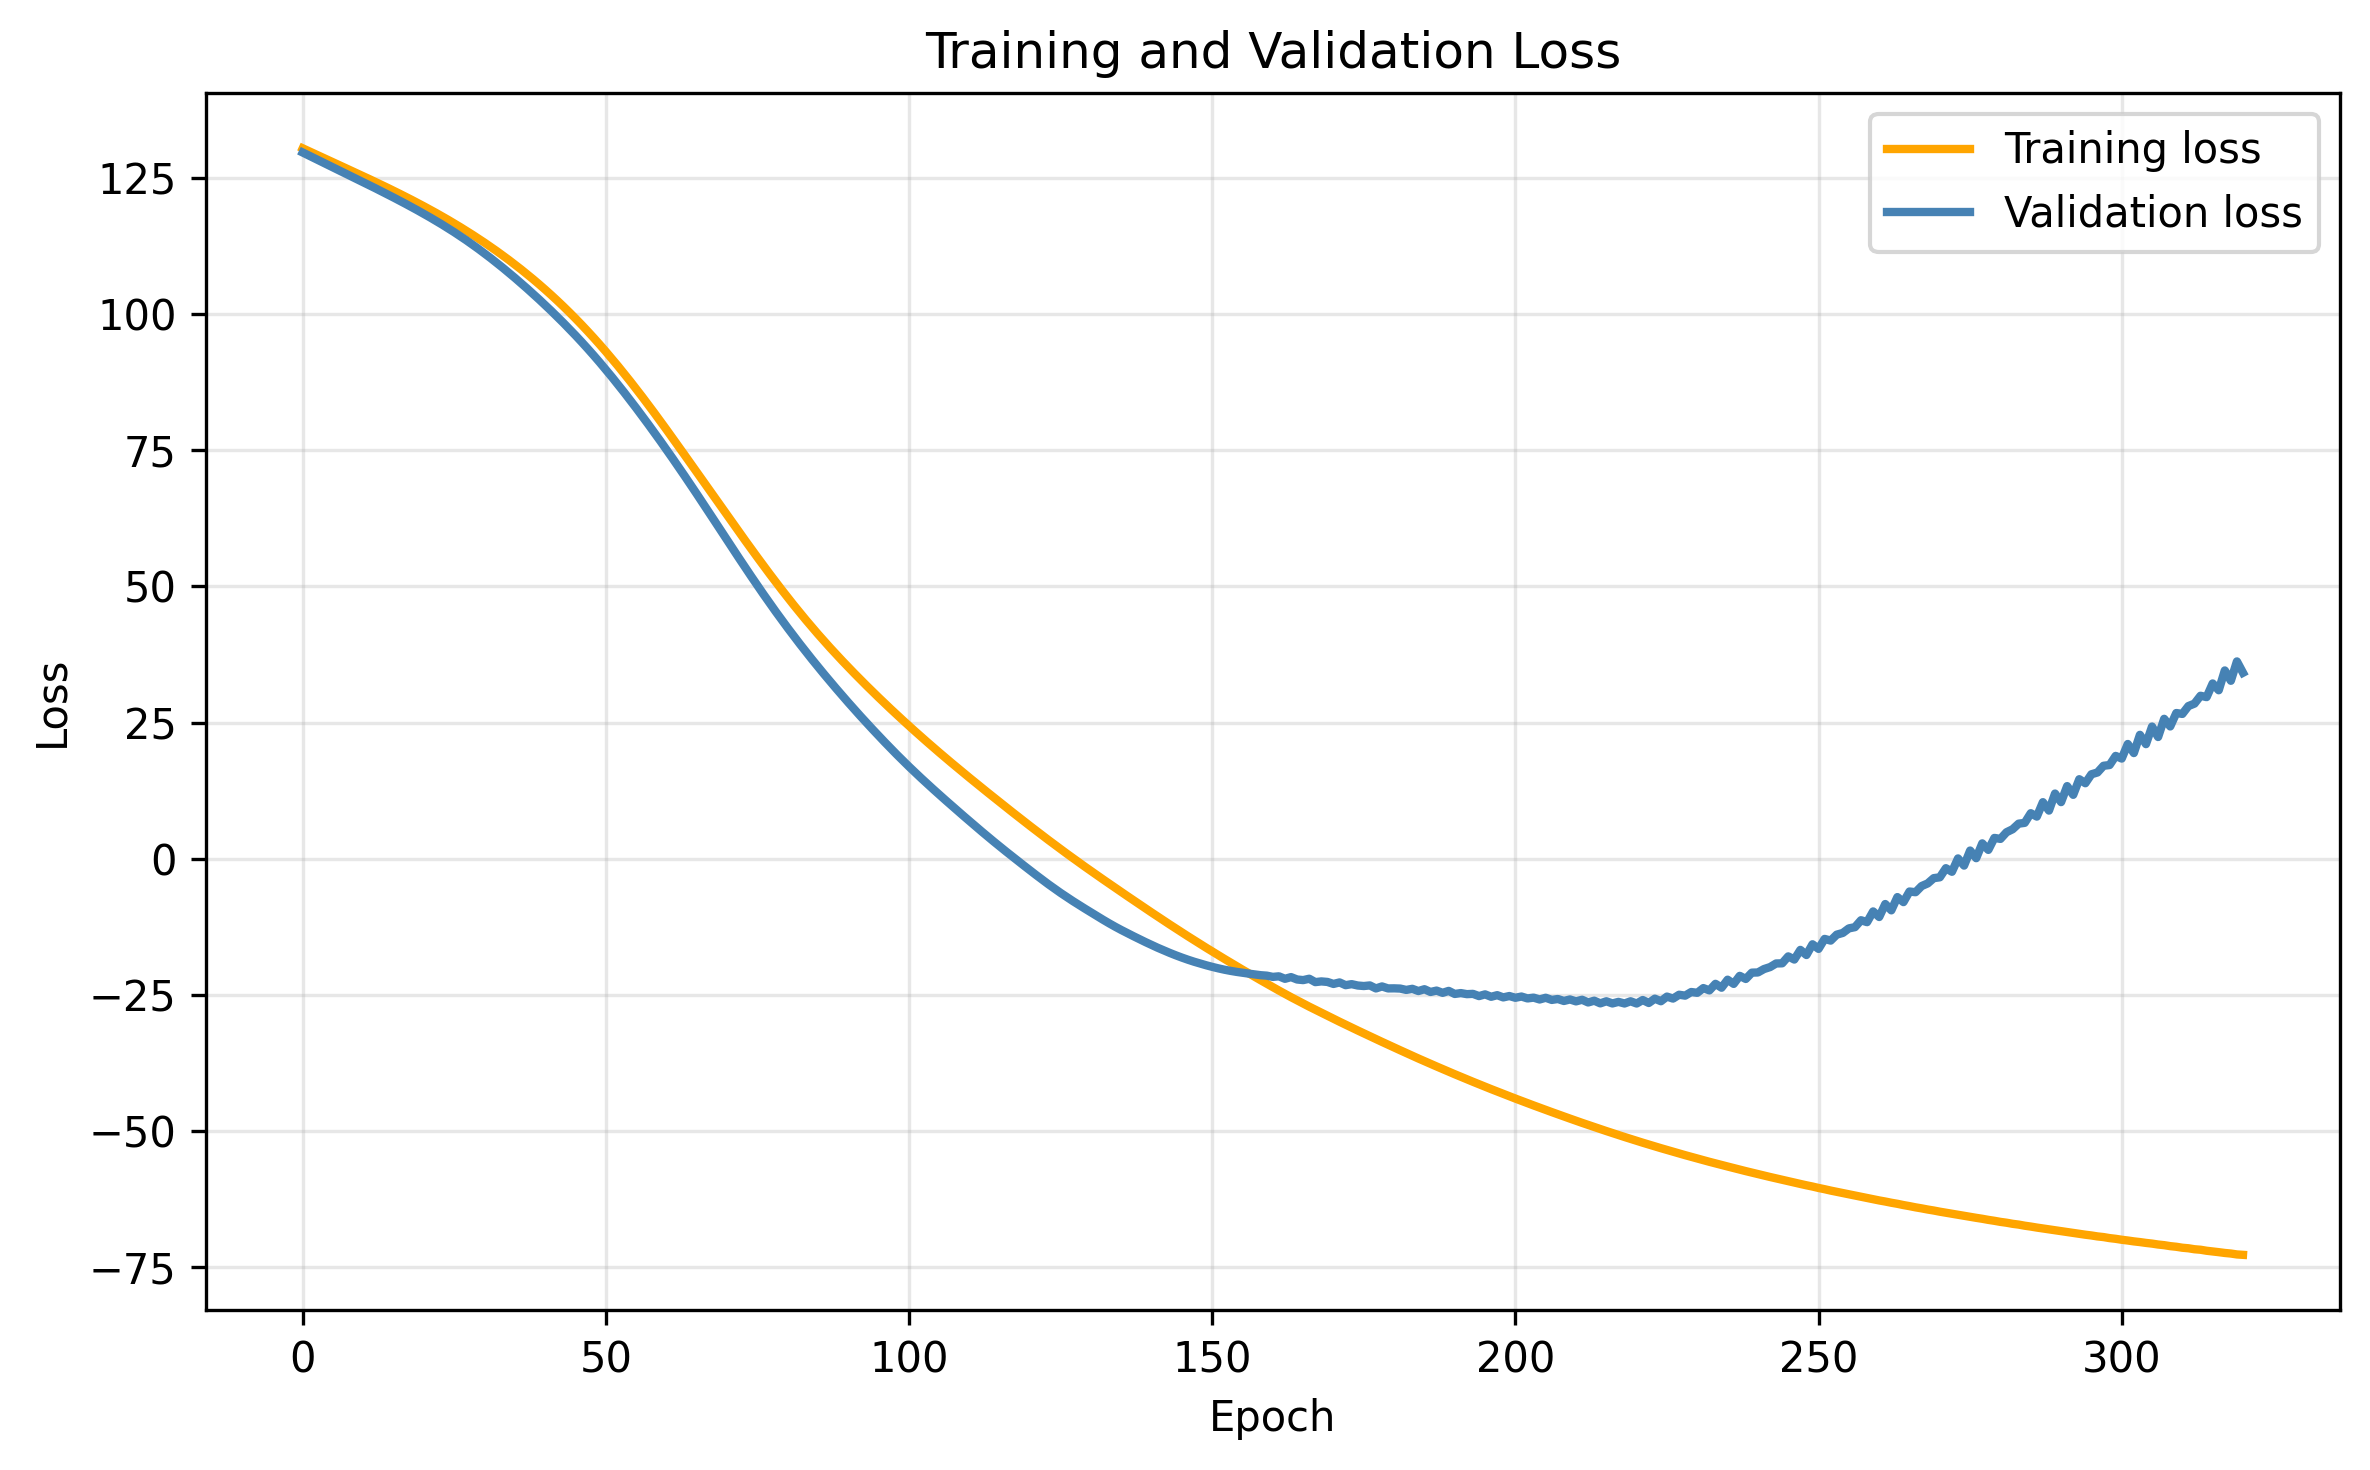

In [99]:
train_loss = np.array(inference._summary.get("training_loss", []))
val_loss = np.array(inference._summary.get("validation_loss", []))

if len(train_loss) == 0 and len(val_loss) == 0:
    raise ValueError("No training or validation losses found in inference._summary.")
# end if

# Align lengths
n_epochs = max(len(train_loss), len(val_loss))
epochs = np.arange(1, n_epochs + 1)

# --- Plot ---
fig = plt.figure(figsize=(8, 5), dpi=300)
if len(train_loss) > 0:
    plt.plot(train_loss, label="Training loss", color="orange", linewidth=2)
# end if

if len(val_loss) > 0:
    plt.plot(val_loss, label="Validation loss", color="steelblue", linewidth=2)
# end if

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

In [100]:
# Build posterior
posterior = inference.build_posterior(density_estimator)
print(posterior)

Posterior p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


### Visualizing the learned posterior

In [121]:
obs_idx = 4
x_obs = x[obs_idx:obs_idx+1, :]
print(f"x_obs: {x_obs.shape}")

x_obs: torch.Size([1, 108])


In [122]:
samples = posterior.sample((100,), x=x_obs)
print(f"Sample shape: {samples.shape}")

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Sample shape: torch.Size([100, 60])


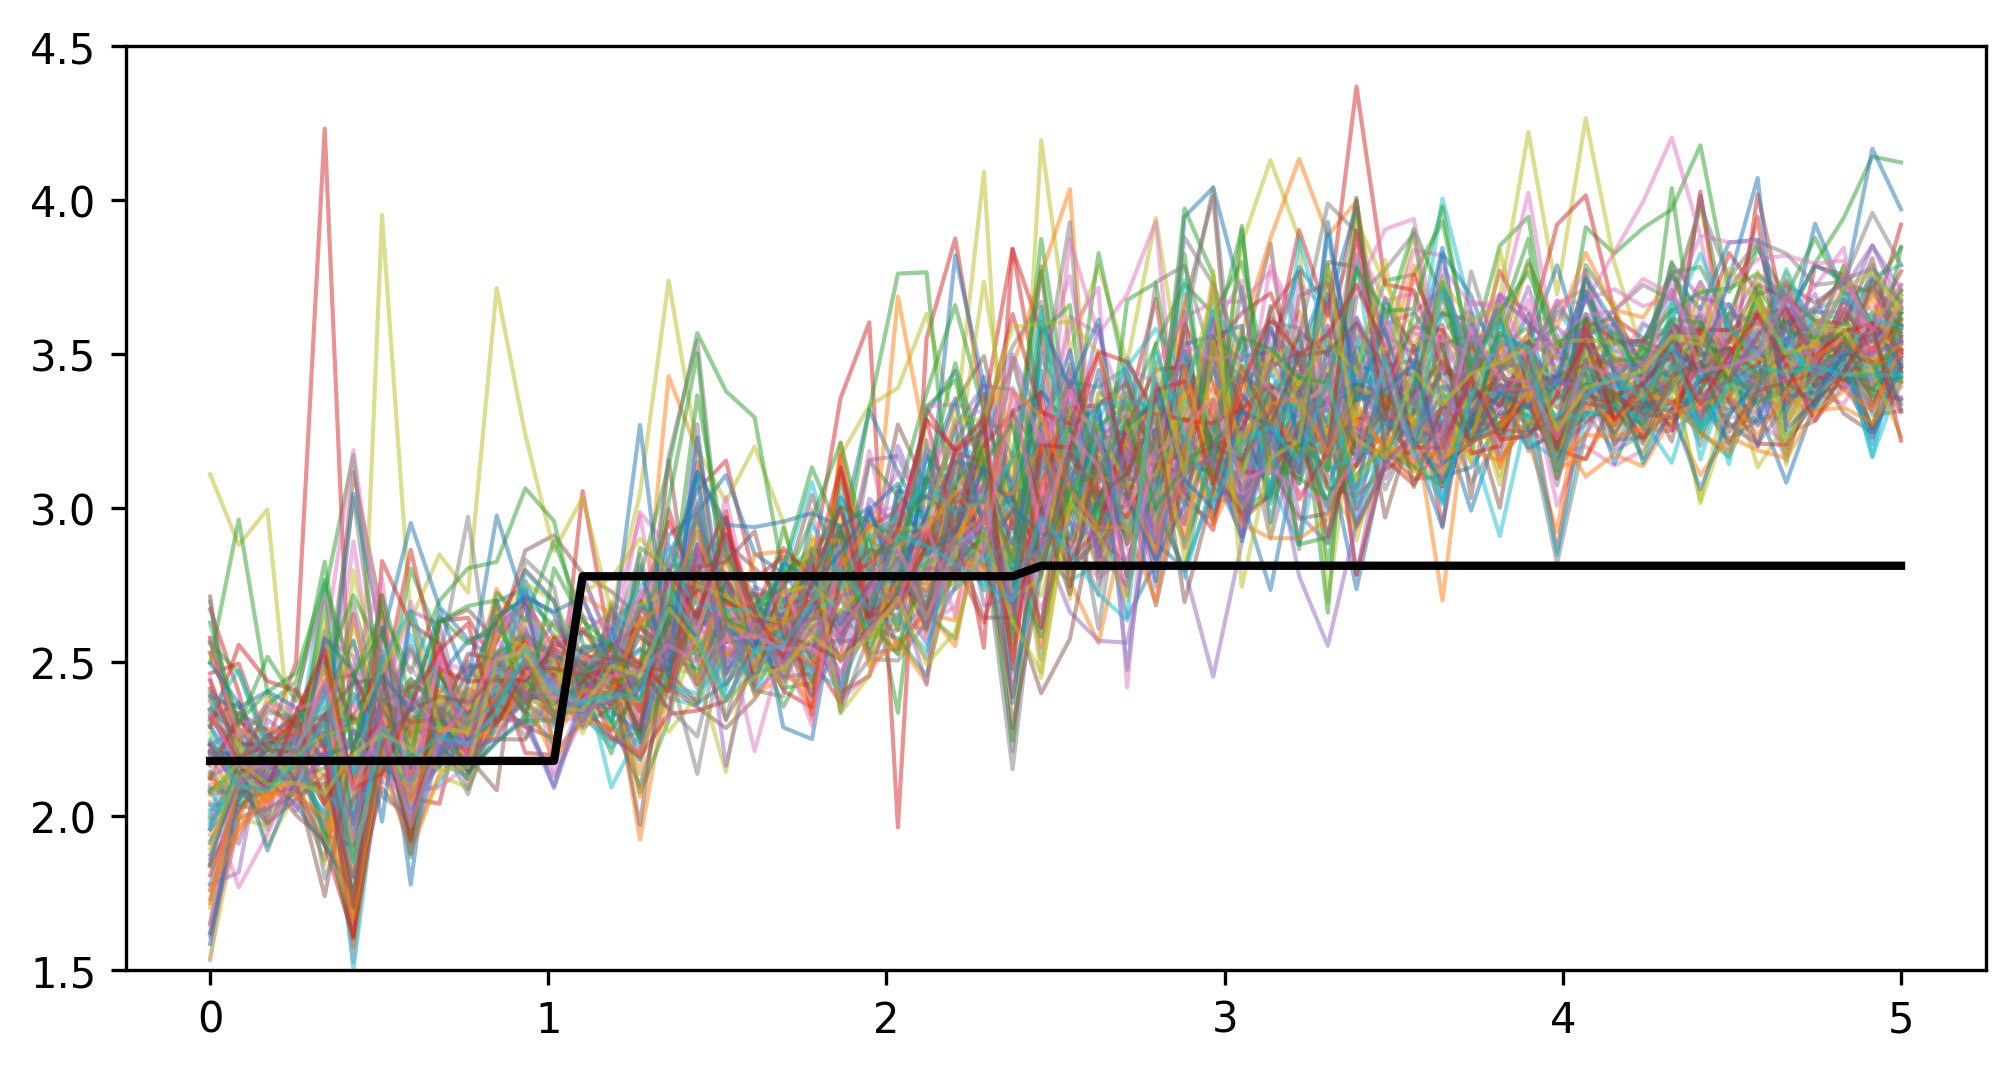

In [123]:
plt.figure(figsize=(8, 4), dpi=300)
for i in range(100):
    plt.plot(z, samples[i], linewidth=1, alpha=0.5)
# end for
plt.plot(z, theta[0], 'black', linewidth=2)
plt.ylim(vs_min, vs_max)
plt.show()

## Working with Pre-Trained Models

### Motivation

### Loading a pre-trained model

### Sampling and visualization

## Model Validation and Diagnostics

### Posterior Predictive Check (PPC)

### Misfit distributions

### Expected Coverage and Calibration

### Simulation-Based Calibration (SBC)

### Visual summary

## Advanced Discussion — Sensitivity and Generalization

### Effect of the prior

### Sequential methods

### Out-of-distribution and generalization